In [6]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
def check(model, epochs=20, batch_size=128, verbose=0):
    model.compile(
        loss="mean_squared_error",
        optimizer="nadam",
        metrics=["accuracy"]
    )
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), verbose=verbose, batch_size=batch_size)
    model.evaluate(X_valid, y_valid)
    
    return model

In [5]:
# naive forecasting
y_pred = X_valid[:, -1]

np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-30 16:58:47.741141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-30 16:58:47.741324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


0.020211367

In [6]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model = check(model)

2022-05-30 16:58:48.064288: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-30 16:58:48.699668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 16:58:50.788462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 5ms/step - loss: 0.0056 - accuracy: 0.0000e+00


In [7]:
# so we need to beat the mse of 0.005

# simple RNN
model = keras.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

with tf.device("cpu"):
    model = check(model)

# it isn't better

2022-05-30 16:59:00.550417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 16:59:03.159846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 26ms/step - loss: 0.0185 - accuracy: 0.0000e+00


In [8]:
model = keras.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

with tf.device("cpu"):
    model = check(model)

# it is a little bit better

2022-05-30 16:59:54.332714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 17:00:03.135129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 4s 69ms/step - loss: 0.0028 - accuracy: 0.0000e+00


In [9]:
model = keras.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1) # this will allow us to change the activation function
])

with tf.device("cpu"):
    model = check(model)

2022-05-30 17:02:17.850198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 17:02:21.306613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 38ms/step - loss: 0.0028 - accuracy: 0.0000e+00


In [10]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [11]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

2022-05-30 17:03:31.098898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


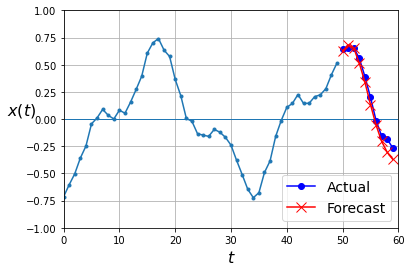

In [12]:
# forecasting multiple frames forward opt1
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [13]:
# opt2 - train RNN to predict 10 values at once

series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [14]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.26648608

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])
model = check(model)

2022-05-30 17:03:35.685932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 17:03:37.019630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 4ms/step - loss: 0.1535 - accuracy: 0.0000e+00


In [16]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

with tf.device("cpu"):
    model = check(model)

2022-05-30 17:03:45.017498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 17:03:48.731581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 51ms/step - loss: 0.1519 - accuracy: 0.0000e+00


In [17]:
# now each time feed next neuron with 10 not 1 predictions
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 11):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])

with tf.device("cpu"):
    history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20


2022-05-30 17:05:15.100006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 0.0517 - last_time_step_mse: 0.0413

2022-05-30 17:05:28.965718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 18s 76ms/step - loss: 0.0517 - last_time_step_mse: 0.0413 - val_loss: 0.0435 - val_last_time_step_mse: 0.0344
Epoch 2/20
219/219 [==============================] - 20s 93ms/step - loss: 0.0392 - last_time_step_mse: 0.0281 - val_loss: 0.0339 - val_last_time_step_mse: 0.0193
Epoch 3/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0333 - last_time_step_mse: 0.0211 - val_loss: 0.0308 - val_last_time_step_mse: 0.0184
Epoch 4/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0305 - last_time_step_mse: 0.0185 - val_loss: 0.0279 - val_last_time_step_mse: 0.0153
Epoch 5/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0272 - last_time_step_mse: 0.0154 - val_loss: 0.0268 - val_last_time_step_mse: 0.0136
Epoch 6/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0254 - last_time_step_mse: 0.0135 - val_loss: 0.0267 - val_last_time_step_mse: 0.0150
Epoch 7/20
219/219 [=======

In [19]:
# RNN Cell that applies Layer Normalization at each time step
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [20]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True, dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# droput - dropout to apply to inputs ar each time step
# recurrent_dropout - dropout to apply to hidden state

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

with tf.device("cpu"):
    history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20


2022-05-30 17:10:36.074295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 0.1708 - last_time_step_mse: 0.1621

2022-05-30 17:11:01.318770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 32s 134ms/step - loss: 0.1708 - last_time_step_mse: 0.1621 - val_loss: 0.0647 - val_last_time_step_mse: 0.0536
Epoch 2/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0663 - last_time_step_mse: 0.0559 - val_loss: 0.0496 - val_last_time_step_mse: 0.0394
Epoch 3/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0511 - last_time_step_mse: 0.0404 - val_loss: 0.0430 - val_last_time_step_mse: 0.0313
Epoch 4/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0440 - last_time_step_mse: 0.0315 - val_loss: 0.0394 - val_last_time_step_mse: 0.0259
Epoch 5/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0399 - last_time_step_mse: 0.0267 - val_loss: 0.0356 - val_last_time_step_mse: 0.0222
Epoch 6/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0364 - last_time_step_mse: 0.0230 - val_loss: 0.0328 - val_last_time_step_mse: 0.0196
Epoch 7/20
219/219 [=

In [21]:
# LSTM (Long Short-Term Memory)
# performs better than normal RNN cells and trains quicker
# runs only on GPU

model = keras.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [22]:
# using 1D conv to preprocess entries

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [25]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((7000, 50, 1), (7000, 50, 10), (2000, 50, 1), (2000, 50, 10))

In [30]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20


2022-05-30 17:23:27.958824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 0.0659 - last_time_step_mse: 0.0549

2022-05-30 17:23:36.089966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 10s 36ms/step - loss: 0.0659 - last_time_step_mse: 0.0549 - val_loss: 0.0352 - val_last_time_step_mse: 0.0226
Epoch 2/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0315 - last_time_step_mse: 0.0186 - val_loss: 0.0296 - val_last_time_step_mse: 0.0164
Epoch 3/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0280 - last_time_step_mse: 0.0155 - val_loss: 0.0273 - val_last_time_step_mse: 0.0146
Epoch 4/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0262 - last_time_step_mse: 0.0137 - val_loss: 0.0259 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0251 - last_time_step_mse: 0.0128 - val_loss: 0.0251 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0244 - last_time_step_mse: 0.0121 - val_loss: 0.0242 - val_last_time_step_mse: 0.0114
Epoch 7/20
219/219 [============

In [31]:
# WaveNet implementation

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

In [35]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20


2022-05-30 17:30:59.713640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 0.0643 - last_time_step_mse: 0.0526

2022-05-30 17:31:06.881980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 9s 36ms/step - loss: 0.0643 - last_time_step_mse: 0.0526 - val_loss: 0.0358 - val_last_time_step_mse: 0.0214
Epoch 2/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0316 - last_time_step_mse: 0.0175 - val_loss: 0.0291 - val_last_time_step_mse: 0.0152
Epoch 3/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0278 - last_time_step_mse: 0.0145 - val_loss: 0.0270 - val_last_time_step_mse: 0.0141
Epoch 4/20
219/219 [==============================] - 44s 200ms/step - loss: 0.0258 - last_time_step_mse: 0.0129 - val_loss: 0.0251 - val_last_time_step_mse: 0.0121
Epoch 5/20
219/219 [==============================] - 78s 359ms/step - loss: 0.0247 - last_time_step_mse: 0.0123 - val_loss: 0.0242 - val_last_time_step_mse: 0.0115
Epoch 6/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0238 - last_time_step_mse: 0.0115 - val_loss: 0.0234 - val_last_time_step_mse: 0.0107
Epoch 7/20
219/219 [=========

In [37]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, cache_subdir="datasets/quickdraw", extract=True)

1065312256/1065301781 [==============================] - 315s 0us/step


In [39]:
from pathlib import Path

In [47]:
parent_dir = Path(filepath).parent

train_files = sorted([str(x) for x in parent_dir.glob("training.tfrecord-*")])
test_files = sorted([str(x) for x in parent_dir.glob("eval.tfrecord-*")])

In [48]:
with open(parent_dir / "training.tfrecord.classes") as f:
    train_classes = [x.strip().lower() for x in f.readlines()]
with open(parent_dir / "eval.tfrecord.classes") as f:
    test_classes = [x.strip().lower() for x in f.readlines()]

In [50]:
# they are the same
assert test_classes == train_classes

In [51]:
class_names = train_classes

In [62]:
def parse(batch):
    desc = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64),
    }

    examples = tf.io.parse_example(batch, desc)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [63]:
def quickdraw(filepaths, batch_size=64, shuffle_size=None, n_parse_threads=8, n_read_threads=8, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)

    if cache:
        dataset = dataset.cache()
    if shuffle_size:
        dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [64]:
train_set = quickdraw(train_files, shuffle_size=10000)
valid_set = quickdraw(test_files[:5])
test_set = quickdraw(test_files[5:])


In [65]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]

    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coords = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coords, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "unknown"
    plt.title(title)
    plt.plot(coords[:, 0], -coords[:, 1], "y:")
    for stroke in strokes: 
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

In [66]:
def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for idx, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, idx + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

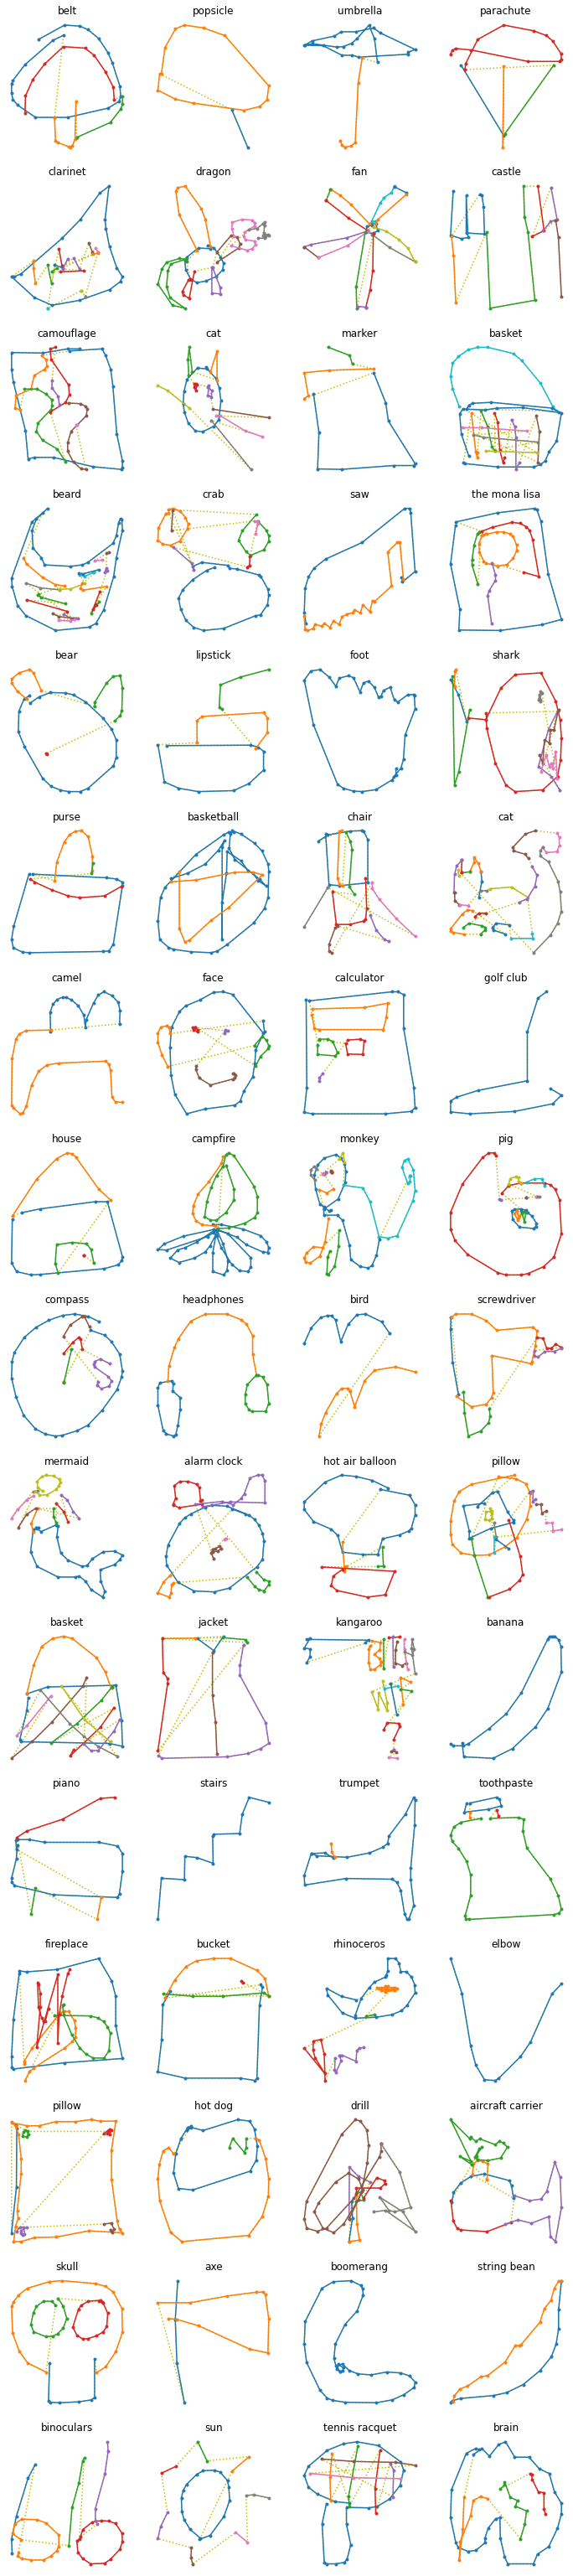

In [67]:
for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

In [69]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax"),
])

In [70]:
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

In [ ]:
history = model.fit(train_set, epochs=4, validation_data=valid_set)

In [7]:
# exerice 10
src =  "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
name = "jsb_chorales.tgz"

filepath = keras.utils.get_file(name, src + name, cache_subdir="datasets/jsb_chorales", extract=True)

In [9]:
from pathlib import Path
root = Path(filepath).parent

train_files = sorted(root.glob("train/chorale_*.csv"))
valid_files = sorted(root.glob("valid/chorale_*.csv"))
test_files = sorted(root.glob("test/chorale_*.csv"))

In [10]:
import pandas as pd

def load(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train = load(train_files)
test = load(test_files)
valid = load(valid_files)

In [11]:
notes = set()

for chorales in (train, test, valid):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

min_note, max_note

(36, 81)

In [21]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next node at each step
    return X, Y
def preprocess(window):
    window = tf.where(window==0, window, window - min_note + 1)
    return tf.reshape(window, [-1])
def batch_dataset(chorales, batch_size=64, schuffle_buffer_size=None, window_size=64, window_schift=16, cache=True):
    def batch_window(window): 
        return window.batch(window_size + 1)
    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_schift, drop_remainder=True)
        return dataset.flat_map(batch_window)
    
    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if schuffle_buffer_size:
        dataset = dataset.shuffle(schuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

In [22]:
train_set = batch_dataset(train, schuffle_buffer_size=1000)
valid_set = batch_dataset(valid)
test_set = batch_dataset(test)

In [23]:
n_emvedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_emvedding_dims, input_shape=[None]), 
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax"),
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           235       
                                                                 
 conv1d (Conv1D)             (None, None, 32)          352       
                                                                 
 batch_normalization (BatchN  (None, None, 32)         128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 48)          3120      
                                                                 
 batch_normalization_1 (Batc  (None, None, 48)         192       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          6

In [27]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20


2022-05-31 17:10:17.972422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-31 17:10:20.261249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-31 17:10:21.813660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     42/Unknown - 19s 254ms/step - loss: 3.2428 - accuracy: 0.5174

2022-05-31 17:10:36.110150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-31 17:10:36.393335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 23s 333ms/step - loss: 3.2428 - accuracy: 0.5174 - val_loss: 4.6970 - val_accuracy: 0.0428
Epoch 2/20
42/42 [==============================] - 10s 234ms/step - loss: 1.4676 - accuracy: 0.9649 - val_loss: 4.6804 - val_accuracy: 0.1164
Epoch 3/20
42/42 [==============================] - 10s 227ms/step - loss: 1.1332 - accuracy: 1.0317 - val_loss: 4.7816 - val_accuracy: 0.1089
Epoch 4/20
42/42 [==============================] - 10s 238ms/step - loss: 1.0081 - accuracy: 1.0537 - val_loss: 4.7784 - val_accuracy: 0.1809
Epoch 5/20
42/42 [==============================] - 10s 227ms/step - loss: 0.9251 - accuracy: 1.0693 - val_loss: 4.4563 - val_accuracy: 0.1448
Epoch 6/20
42/42 [==============================] - 9s 220ms/step - loss: 0.8639 - accuracy: 1.0827 - val_loss: 4.1529 - val_accuracy: 0.2297
Epoch 7/20
42/42 [==============================] - 9s 225ms/step - loss: 0.8143 - accuracy: 1.0933 - val_loss: 4.3697 - val_accuracy: 0.1829
Epoch 8/20
4